In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import sklearn.preprocessing as pp

import warnings

plt.style.use('bmh')
warnings.filterwarnings('ignore')
RS = 8

# IO utils


In [2]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels,      default = 0
                n_gyr_channels  (int): Number of Gyroscope channels,          default = 0
                n_mag_channels  (int): Number of Magnetometer channels,       default = 0
                n_enc_channels  (int): Number of Encoder channels,            default = 0
                button_ch      (bool): If button channel is present,          default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present,       default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Data

In [3]:
palm_file = './data/2023-05-31_17-14-41.palm'
gestures = read_omg_csv(palm_file, 
                        n_omg_channels=50,
                        n_acc_channels=3, 
                        n_gyr_channels=3, 
                        n_enc_channels=6, 
                        n_mag_channels=0)

gestures

0  1  2  3  4  5  6  7   8   9  ...  GYR2  ENC0  ENC1  ENC2  ENC3  \
0      12  8  5  6  2  4  5  7  14   8  ...   -13     0     0     0     0   
1      13  8  4  5  3  0  5  4   9  10  ...   -16     0     0     0     0   
2      12  5  9  5  0  0  6  5  10   9  ...   -14     0     0     0     0   
3      10  7  6  4  1  0  4  6   7   8  ...   -12     0     0     0     0   
4      12  6  6  7  3  2  6  7   9  12  ...   -12     0     0     0     0   
...    .. .. .. .. .. .. .. ..  ..  ..  ...   ...   ...   ...   ...   ...   
19563   3  6  7  4  2  0  6  3  13   8  ...     1     0     0     0     0   
19564  26  6  5  3  2  1  4  4   9   7  ...    -2     0     0     0     0   
19565  14  7  6  4  2  0  6  5  13   8  ...     0     0     0     0     0   
19566  30  6  6  4  2  0  5  5  10   6  ...    -1     0     0     0     0   
19567  11  6  6  4  2  1  5  5  11   7  ...    -3     0     0     0     0   

       ENC4  ENC5  BUTTON  SYNC       ts  
0         0     0       0     0   555777  
1         0     0       0     0   555810  
2         0     0       0     0   555843  
3         0     0       0     0   555876  
4         0     0       0     0   555909  
...     ...   ...     ...   ...      ...  
19563     0     0       0     0  1201356  
19564     0     0       0     0  1201389  
19565     0     0       0     0  1201422  
19566     0     0       0     0  1201455  
19567     0     0       0     0  1201488  

[19568 rows x 65 columns]

### Abbreviations
* OMG — optomiography  
* ACC — accelerometer  
* GYR — gyroscope  
* ENC — encoders (fingers of prosthesis or gloves)  
* model — model of data  

### X features 
* '0', ..., '49' - каналы OMG датчиков
* 'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
* 'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
* 'BUTTON' - не используется
* 'SYNC' - синхронизация данных с протоколом
* 'ts' - метка времени

In [4]:
gestures.columns 

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [5]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


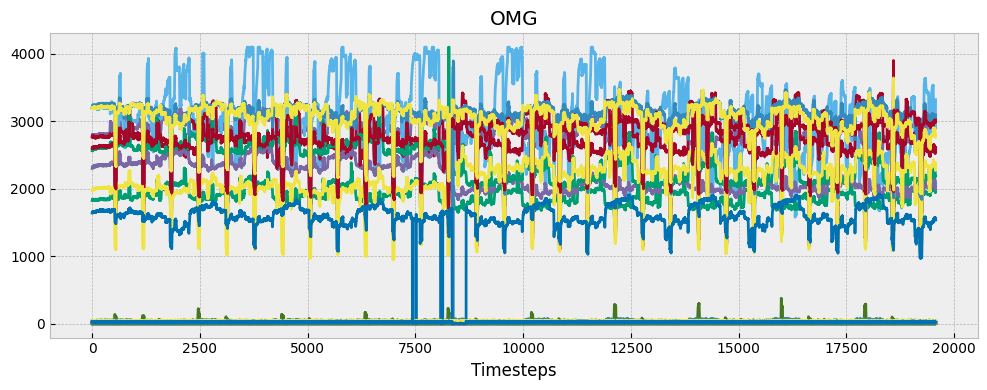

In [6]:
fig = plt.figure(figsize=(10, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

# Protocol

In [7]:
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)

gestures_protocol

Thumb  Index  Middle  Ring  Pinky  Thumb_stretch  Index_stretch  \
epoch                                                                    
0        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
1        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
2        1.0    0.0     0.0   0.0    0.0            0.0            0.0   
3        1.0    1.0     1.0   1.0    1.0            0.0            0.0   
4        0.0    0.0     0.0   0.0    0.0            1.0            1.0   
...      ...    ...     ...   ...    ...            ...            ...   
176      1.0    0.0     0.0   0.0    0.0            0.0            0.0   
177      1.0    1.0     1.0   1.0    1.0            0.0            0.0   
178      0.0    0.0     0.0   0.0    0.0            1.0            1.0   
179      1.0    1.0     0.0   0.0    0.0            0.0            0.0   
180      0.0    0.0     1.0   1.0    1.0            0.0            0.0   

       Middle_stretch  Ring_stretch  Pinky_stretch  Pronation  
epoch                                                          
0                 0.0           0.0            0.0        0.0  
1                 0.0           0.0            0.0        0.0  
2                 0.0           0.0            0.0        0.0  
3                 0.0           0.0            0.0        0.0  
4                 1.0           1.0            1.0        0.0  
...               ...           ...            ...        ...  
176               0.0           0.0            0.0        1.0  
177               0.0           0.0            0.0        1.0  
178               1.0           1.0            1.0        1.0  
179               0.0           0.0            0.0        1.0  
180               0.0           0.0            0.0        1.0  

[181 rows x 11 columns]

In [8]:
gestures['SYNC'].value_counts()

SYNC
0      11266
57        58
67        58
97        47
135       47
       ...  
52        46
1         45
103       45
104       45
12        39
Name: count, Length: 181, dtype: int64

In [9]:
le = pp.LabelEncoder()

# FIT & TRANSFORM
gestures_protocol['gesture'] = le.fit_transform(
    gestures_protocol[[
        "Thumb", "Index", "Middle", "Ring", "Pinky",
        'Thumb_stretch', 'Index_stretch', 'Middle_stretch', 'Ring_stretch', 'Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

display(np.c_[le.transform(le.classes_), le.classes_])

gestures_protocol['gesture']

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

epoch
0      0
1      0
2      3
3      5
4      1
      ..
176    3
177    5
178    1
179    4
180    2
Name: gesture, Length: 181, dtype: int32

In [10]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [11]:
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

y_cmd, len(y_cmd)

(array([0, 0, 0, ..., 0, 0, 0]), 19568)

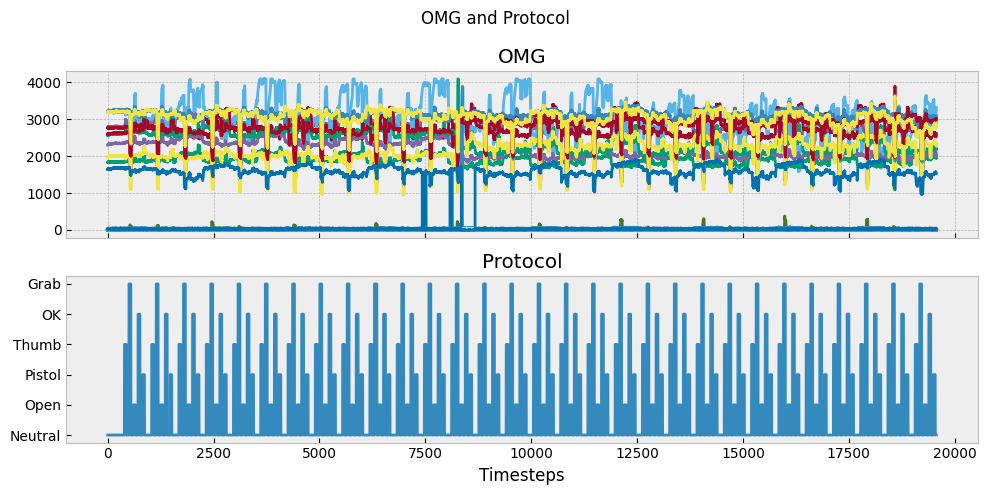

In [12]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

# Preprocessing

### Delete useless columns

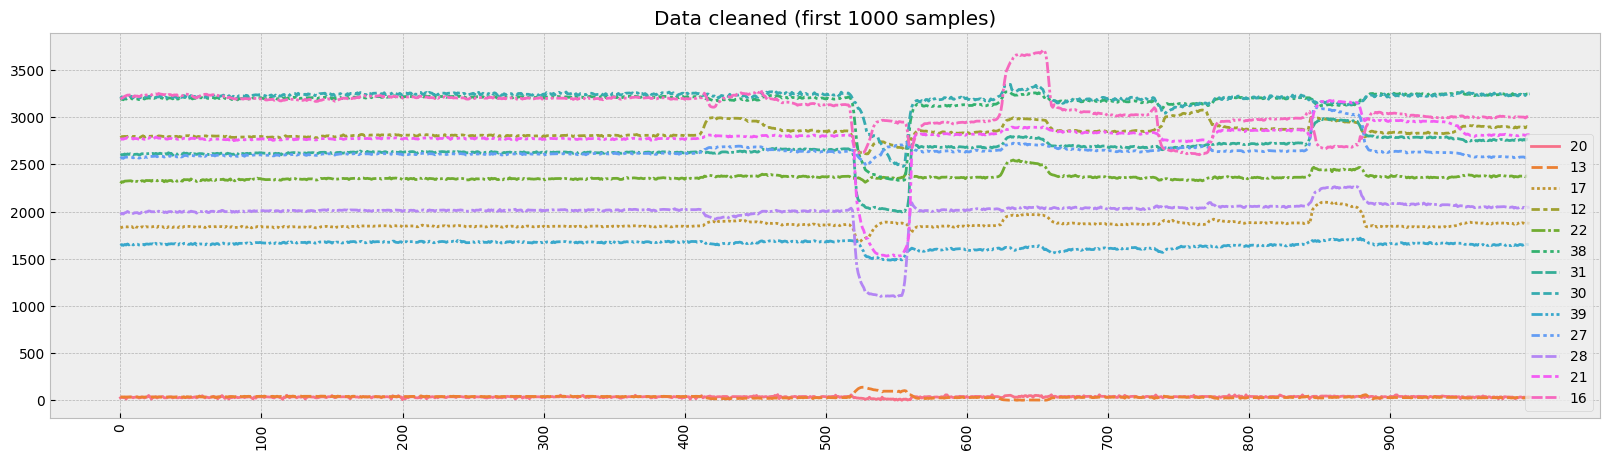

In [13]:
gest_std = (gestures[OMG_CH]
            .std(axis=0)
            .sort_values())

gest_good_i = (gest_std
               .where(gest_std >= 10)
               .dropna()
               .index)

gestures_omg_ch = gestures[OMG_CH].loc[:, gest_good_i]


plt.figure(figsize=(20, 5))
sns.lineplot(gestures_omg_ch.iloc[:1000])

plt.xticks(range(0, 1000, 100), rotation=90)
plt.title('Data cleaned (first 1000 samples)')
plt.show() 

### *Delay problem*

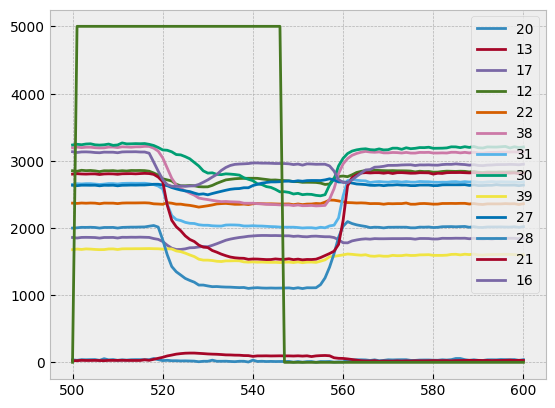

In [14]:
gestures_omg_ch.loc[500:600].plot(kind='line') 
pd.Series(y_cmd).loc[500:600].mul(1000).plot(kind='line') 

plt.show()

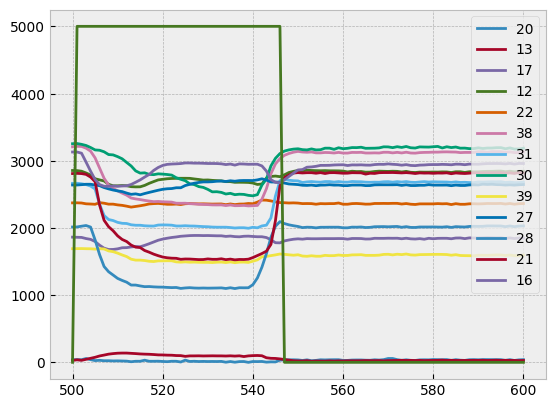

In [15]:
gestures_omg_ch.shift(-15).loc[500:600].plot(kind='line') 
pd.Series(y_cmd).loc[500:600].mul(1000).plot(kind='line') 

plt.show()

### Correlations

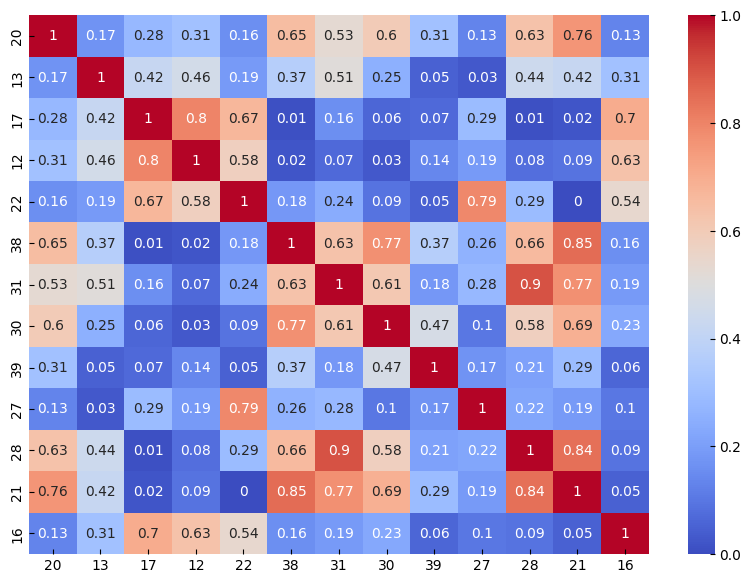

In [16]:
plt.figure(figsize=(10, 7))
sns.heatmap(gestures_omg_ch.corr().abs().round(2), 
            annot=True, 
            cmap='coolwarm')

plt.show()

In [17]:
gestures_omg_ch.drop('28', axis=1, inplace=True) 

### Scaling

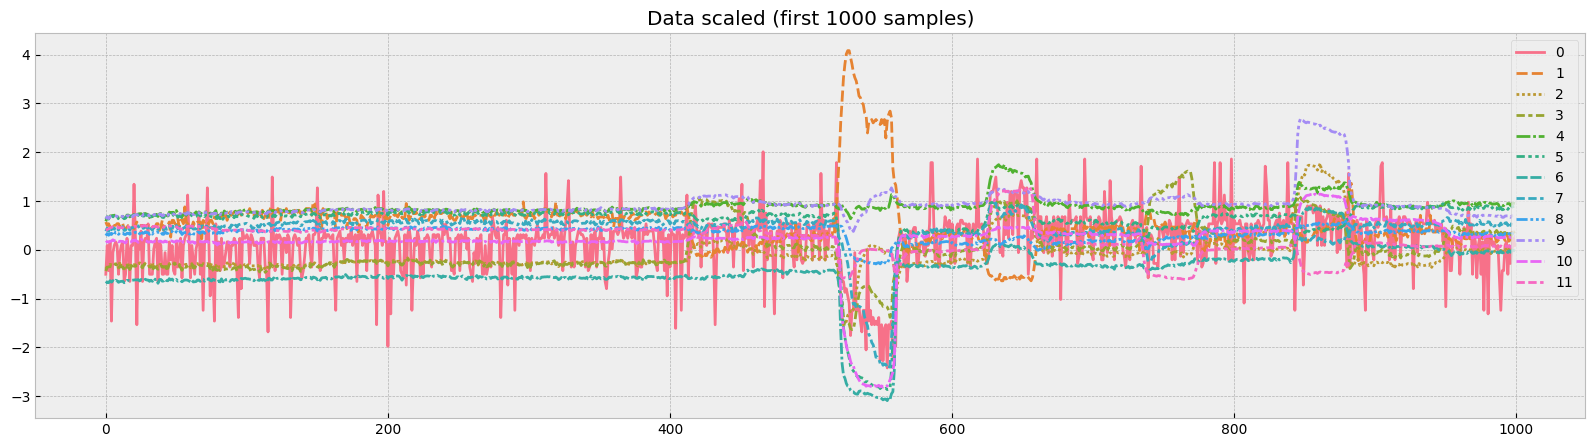

In [18]:
scaler = pp.StandardScaler()

X_data = pd.DataFrame(
    scaler.fit_transform(gestures_omg_ch)
)

plt.figure(figsize=(20, 5))
sns.lineplot(X_data.iloc[:1000])

plt.title('Data scaled (first 1000 samples)')
plt.show() 

# Train-test split

In [19]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
df_meta.head() 

montage  pilote_id  last_train_idx  len(train)  len(test)
0  2023-05-15_16-16-08.palm          1           23337       23337       5810
1  2023-05-15_17-12-24.palm          1           23336       23336       5803
2  2023-06-05_16-12-38.palm          1           17939       17939       4431
3  2023-06-05_17-53-01.palm          1           17771       17771       4435
4  2023-06-20_14-43-11.palm          1           17936       17936       4441

In [20]:
last_train_idx = (df_meta[df_meta['montage'] == palm_file.split('/')[-1]]
                  ['last_train_idx'].values[0]) 

last_train_idx 

15679

In [21]:
X_train = X_data.loc[:last_train_idx-1]
y_train = y_cmd[:last_train_idx]

X_test = X_data.loc[last_train_idx:]
y_test = y_cmd[last_train_idx:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15679, 12) (15679,)
(3889, 12) (3889,)


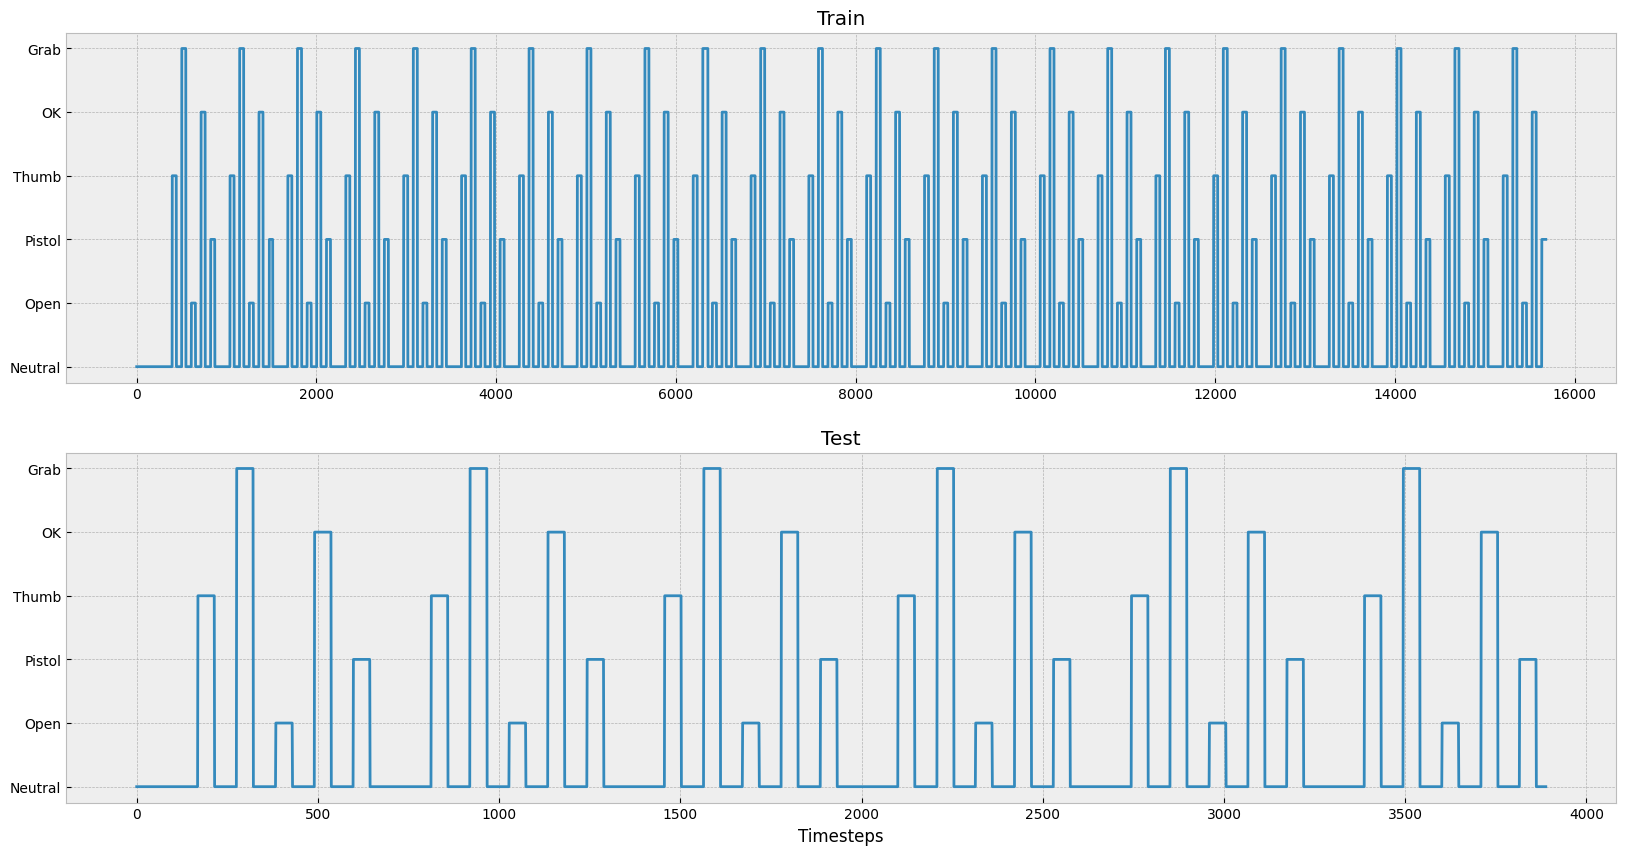

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(y_train, ax=ax[0])
sns.lineplot(y_test, ax=ax[1])

ax[0].set_yticks(range(len(GESTURES)), GESTURES)
ax[0].set_title('Train')

ax[1].set_xlabel('Timesteps')
ax[1].set_yticks(range(len(GESTURES)), GESTURES)
ax[1].set_title('Test')

fig.show()

# Modeling, Prediction & Metrics

In [23]:
import sklearn.linear_model as lm 
import sklearn.tree as t
import sklearn.ensemble as ens 
import sklearn.neighbors as n
import sklearn.svm as svm
import sklearn.metrics as m

import optuna

RS = 8 #random_state

In [24]:
def shift_data(shift_value,
               X_data=X_data,
               y_data=y_cmd):     
    X_shifted = X_data.shift(-shift_value).dropna()
    y_shifted = y_data[:-shift_value]
    
    X_train = X_shifted.loc[:last_train_idx-1]
    y_train = y_shifted[:last_train_idx]

    X_test = X_shifted.loc[last_train_idx:]
    y_test = y_shifted[last_train_idx:]
    
    return X_train, X_test, y_train, y_test


def show_shift_plot(model, shifts=(range(1, 26))):
    train_scores = []
    test_scores = []

    for s in shifts:
        X_train, X_test, y_train, y_test = shift_data(s)
        
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        train_f1 = m.f1_score(y_train, y_pred_train, average='weighted')
        test_f1 = m.f1_score(y_test, y_pred_test, average='weighted')
        
        train_scores.append(train_f1)
        test_scores.append(test_f1)
        

    scores_df = pd.DataFrame({'train': train_scores, 
                              'test': test_scores}, 
                             index=shifts)

    plt.figure(figsize=(15, 5))
    sns.lineplot(scores_df)

    plt.xticks(shifts)
    plt.xlabel('Shift value')
    plt.ylabel('Weighted F1 score')
    plt.title(str(model).split('(')[0])
    
    plt.show()

In [25]:
def print_error(func):
    def func_w_error(*args, **kwargs):
        try:
            func(*args, **kwargs)
        except ValueError as ve:
            return ve
    
    return func_w_error


@print_error
def model_report(model, shift_value):        
    X_train, X_test, y_train, y_test = shift_data(shift_value)
    
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    if ((len(np.unique(y_pred_train)) != len(GESTURES)) or 
        (len(np.unique(y_pred_test)) != len(GESTURES))):
        raise ValueError('Bad prediction') 
    
    train_f1 = 100 * m.f1_score(y_train, 
                                y_pred_train, 
                                average='weighted')
    test_f1 = 100 * m.f1_score(y_test, 
                               y_pred_test, 
                               average='weighted')

    print(f'Train:  {train_f1.round(2)} %\n')
    print(f'Test:   {test_f1.round(2)} %')
    
    fig, ax = plt.subplots(2, 1, figsize=(20, 10))

    y_train_df = pd.DataFrame({'y_train': y_train,
                               'y_pred_train': y_pred_train})
    y_test_df = pd.DataFrame({'y_test': y_test, 
                              'y_pred_test': y_pred_test})

    sns.lineplot(y_train_df, ax=ax[0])
    sns.lineplot(y_test_df, ax=ax[1])

    ax[0].set_yticks(range(len(GESTURES)), GESTURES)
    ax[0].set_title('Train')

    ax[1].set_xlabel('Timesteps')
    ax[1].set_yticks(range(len(GESTURES)), GESTURES)
    ax[1].set_title('Test')

    fig.show()
    
    
def model_score(model, shift_value):        
    X_train, X_test, y_train, y_test = shift_data(shift_value)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if len(np.unique(y_pred)) != len(GESTURES):
        return 0
    else:
        score = m.f1_score(y_test, y_pred, average='weighted')
    
    return score

### Logistic Regression (baseline)

In [68]:
base_model = lm.LogisticRegression(random_state=RS) 

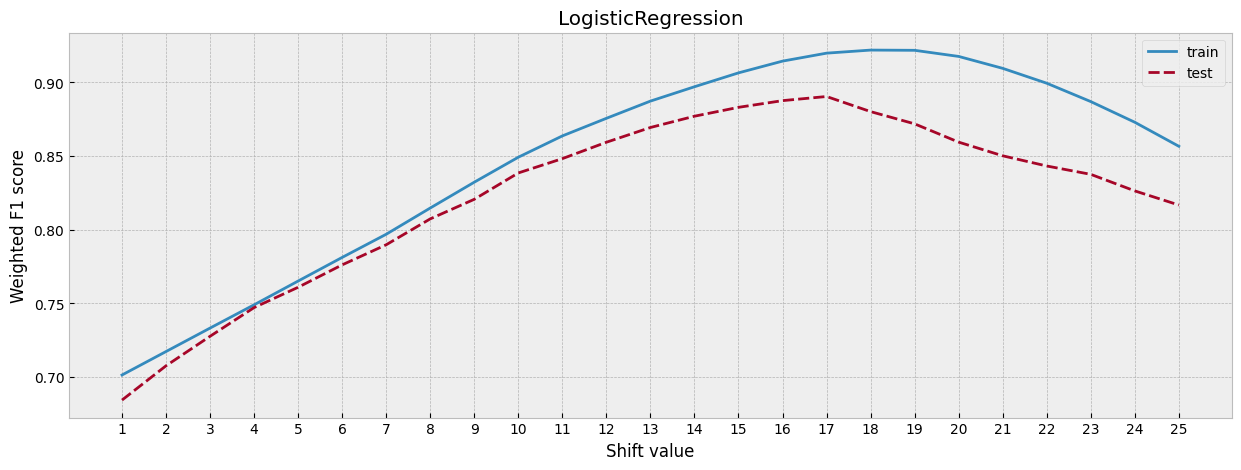

In [27]:
show_shift_plot(base_model) 

Train:  91.98 %

Test:   89.04 %


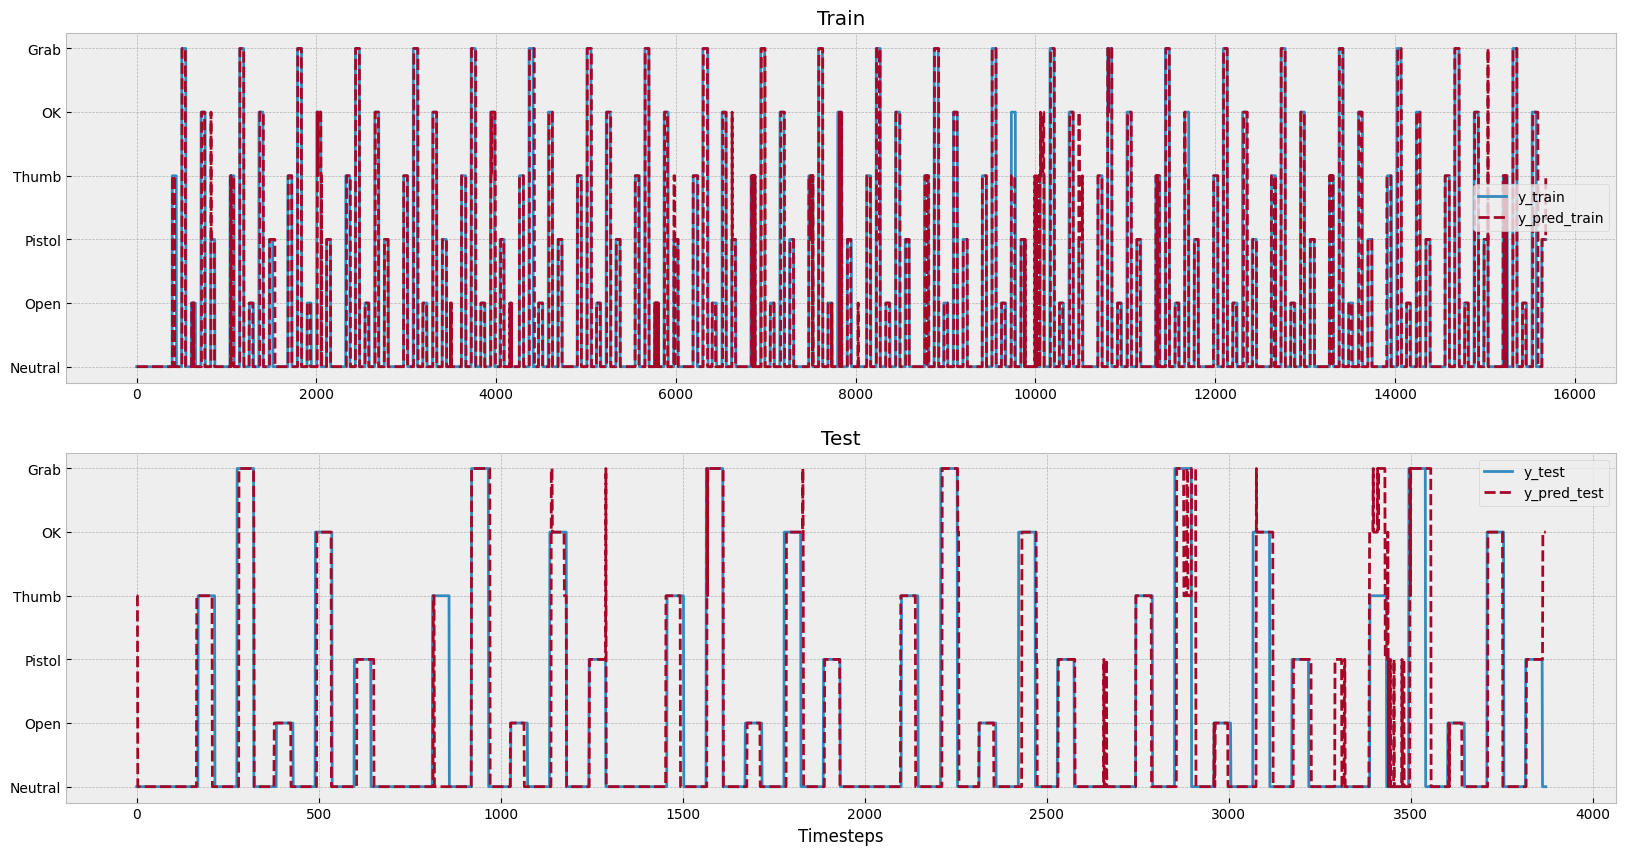

In [28]:
model_report(base_model, 17) 

In [29]:
def opt_logreg(trial: optuna.trial.Trial):
    model = lm.LogisticRegression(
        penalty = trial.suggest_categorical('penalty', ['l2', None]), 
        C = trial.suggest_float('C', 0.0001, 5), 
        multi_class = trial.suggest_categorical('multi_class', ['ovr', 'multinomial']), 
        max_iter = trial.suggest_int('max_iter', 100, 10000, step=100),
        solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'sag', 'saga']),
        random_state = RS
    )
    score = model_score(model, 17)
    
    return score


study_logreg = optuna.create_study(study_name='Logistic Regression', direction='maximize')

study_logreg.optimize(opt_logreg, n_trials=30)

[I 2024-01-27 21:46:02,094] A new study created in memory with name: Logistic Regression
[I 2024-01-27 21:46:02,771] Trial 0 finished with value: 0.8909349881443132 and parameters: {'penalty': 'l2', 'C': 1.6221119856799777, 'multi_class': 'multinomial', 'max_iter': 8100, 'solver': 'sag'}. Best is trial 0 with value: 0.8909349881443132.
[I 2024-01-27 21:46:02,893] Trial 1 finished with value: 0.840778175972213 and parameters: {'penalty': 'l2', 'C': 0.017771429701920024, 'multi_class': 'multinomial', 'max_iter': 6300, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8909349881443132.
[I 2024-01-27 21:46:04,027] Trial 2 finished with value: 0.8915741229110593 and parameters: {'penalty': None, 'C': 1.576637697025759, 'multi_class': 'multinomial', 'max_iter': 9300, 'solver': 'sag'}. Best is trial 2 with value: 0.8915741229110593.
[I 2024-01-27 21:46:05,168] Trial 3 finished with value: 0.8906920370857258 and parameters: {'penalty': 'l2', 'C': 1.5137300361068968, 'multi_class': 'multinomial

Train:  92.11 %

Test:   89.16 %


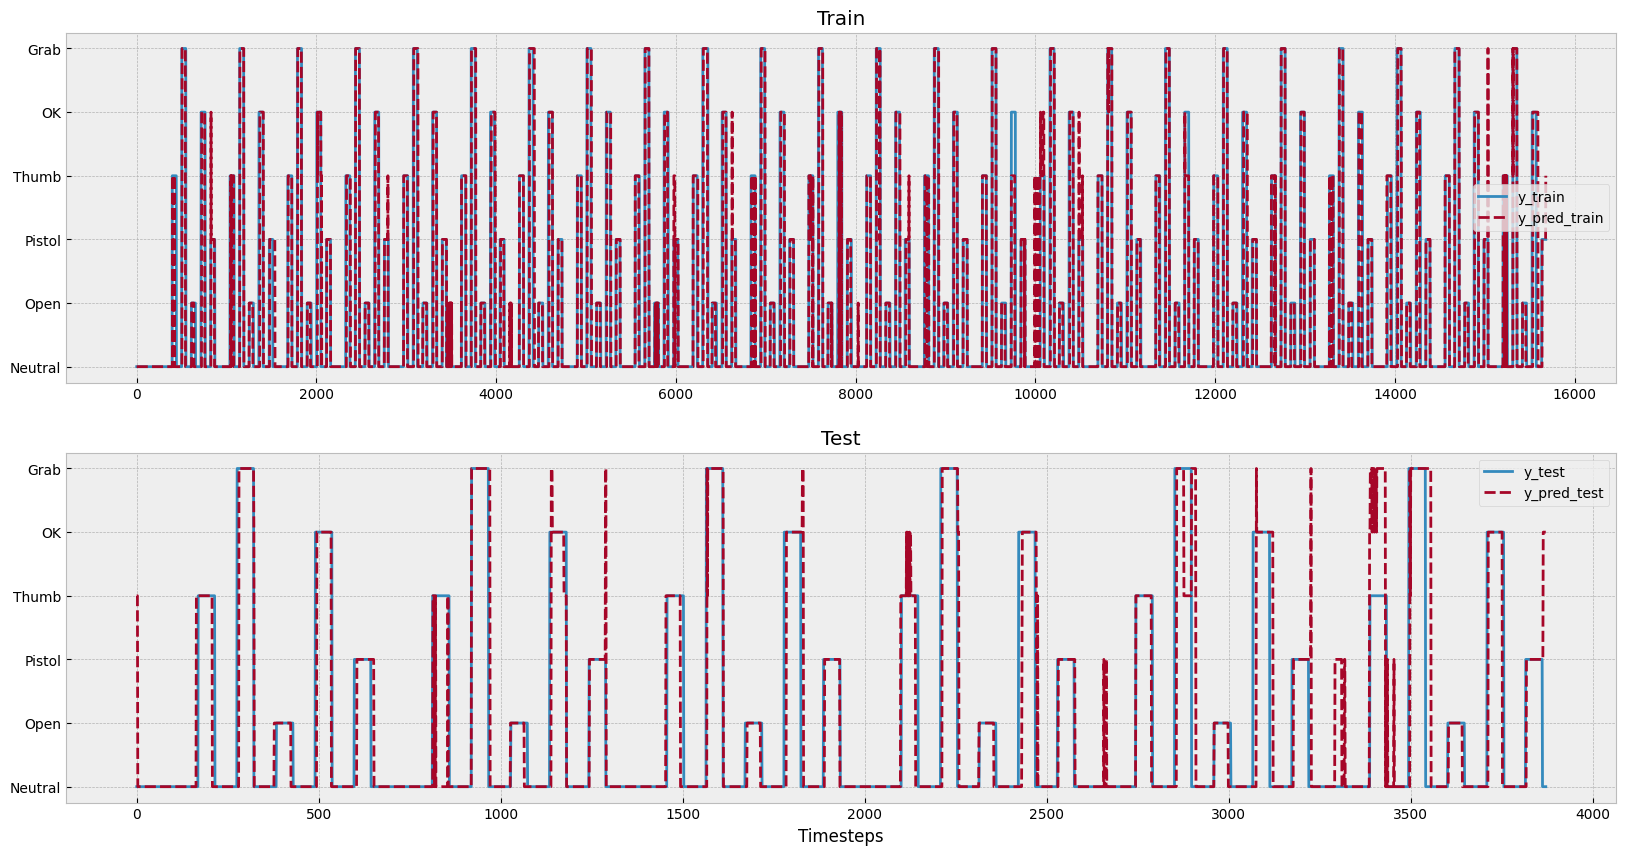

In [30]:
base_opt = base_model.set_params(**study_logreg.best_params)

model_report(base_opt, 17)

### SGD

In [31]:
sgd_model = lm.SGDClassifier(random_state=RS)

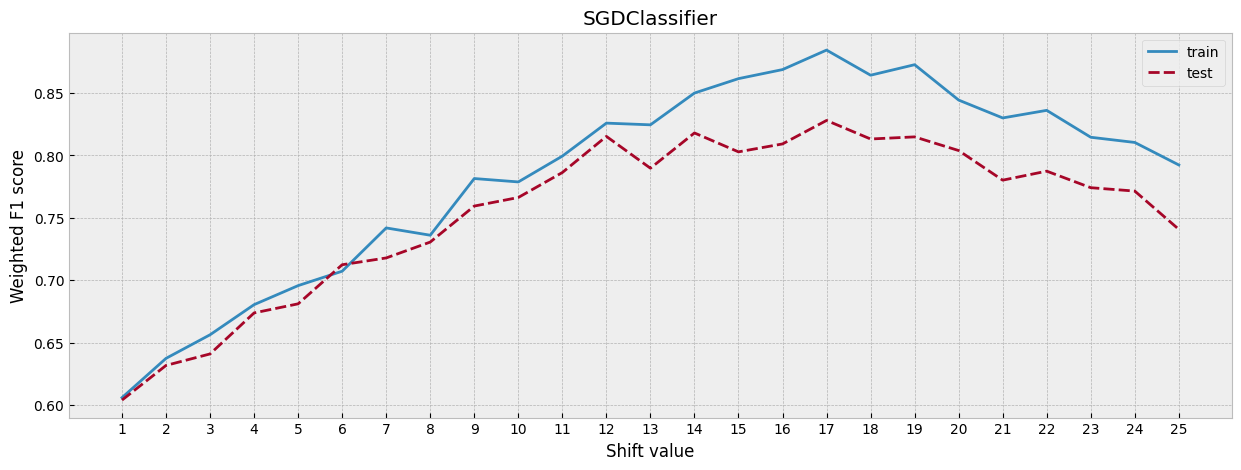

In [32]:
show_shift_plot(sgd_model)

Train:  88.42 %

Test:   82.79 %


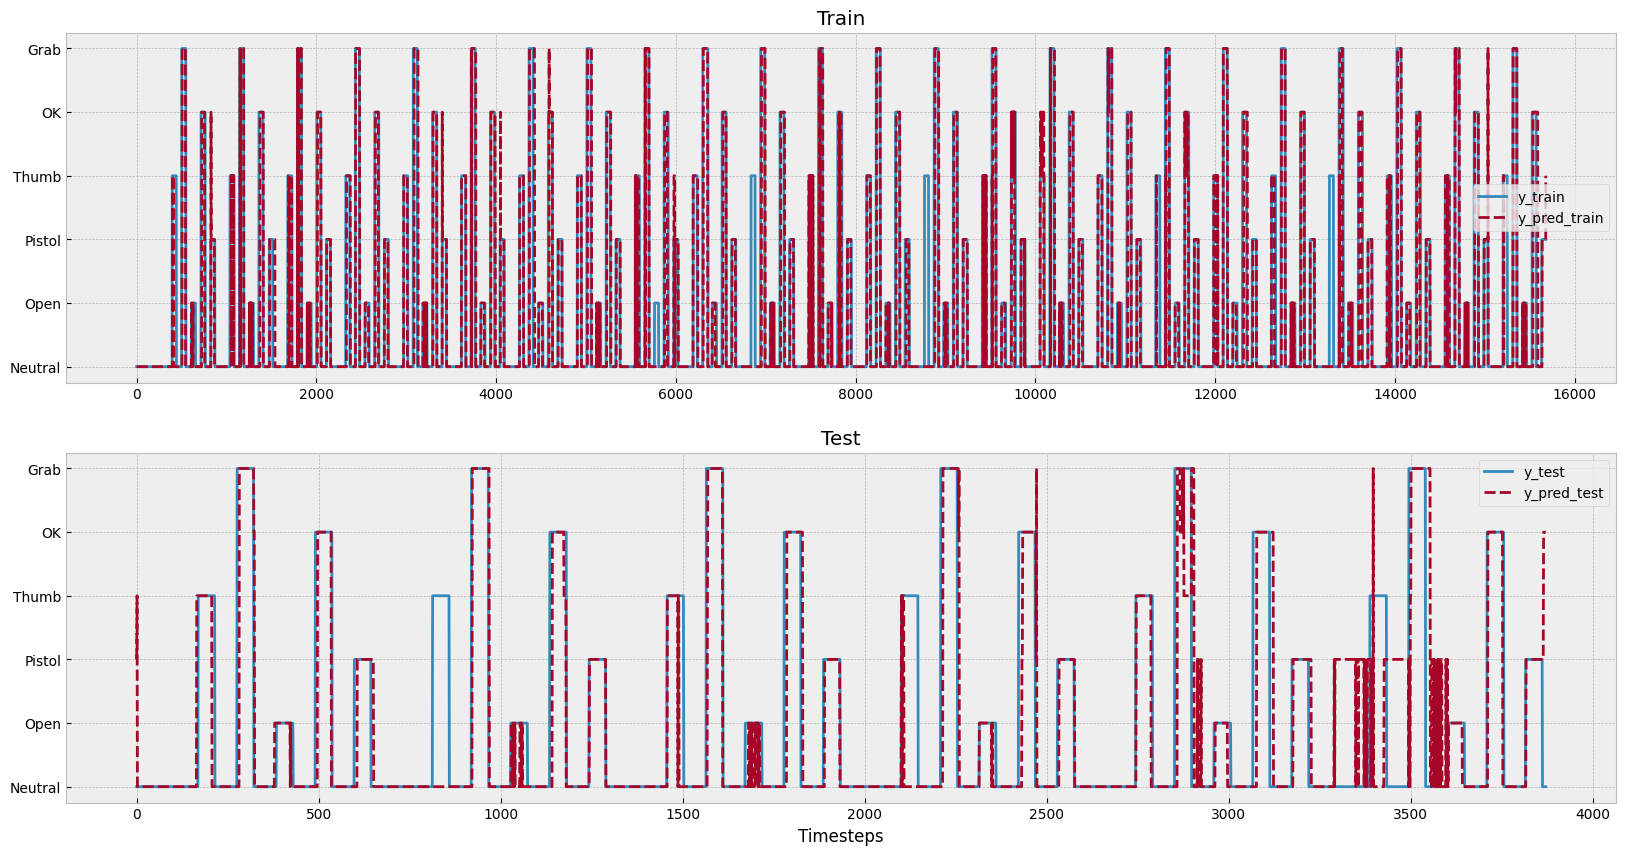

In [33]:
model_report(sgd_model, 17)

In [34]:
def opt_sgd(trial: optuna.trial.Trial):
    model = lm.SGDClassifier(
        loss = trial.suggest_categorical('loss', ['hinge', 
                                                  'log_loss', 
                                                  'modified_huber', 
                                                  'squared_hinge', 
                                                  'perceptron', 
                                                  'squared_error', 
                                                  'huber', 
                                                  'epsilon_insensitive', 
                                                  'squared_epsilon_insensitive']), 
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2', None]), 
        alpha = trial.suggest_float('alpha', 0.00001, 1), 
        learning_rate = trial.suggest_categorical('learning_rate', ['constant', 
                                                                    'optimal',
                                                                    'invscaling',
                                                                    'adaptive']),
        eta0 = trial.suggest_float('eta0', 0.00001, 1), 
        max_iter = trial.suggest_int('max_iter', 100, 10000, step=100),
        random_state = RS
    )
    score = model_score(model, 17)
    
    return score


study_sgd = optuna.create_study(study_name='SGD', direction='maximize')

study_sgd.optimize(opt_sgd, n_trials=30)

[I 2024-01-27 21:46:31,250] A new study created in memory with name: SGD
[I 2024-01-27 21:46:31,630] Trial 0 finished with value: 0.0 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 0.4479362521887528, 'learning_rate': 'adaptive', 'eta0': 0.9422893395126191, 'max_iter': 6700}. Best is trial 0 with value: 0.0.
[I 2024-01-27 21:46:31,695] Trial 1 finished with value: 0.0 and parameters: {'loss': 'huber', 'penalty': None, 'alpha': 0.7378842577841453, 'learning_rate': 'optimal', 'eta0': 0.419921985115435, 'max_iter': 500}. Best is trial 0 with value: 0.0.
[I 2024-01-27 21:46:31,769] Trial 2 finished with value: 0.5970041208261953 and parameters: {'loss': 'perceptron', 'penalty': None, 'alpha': 0.46125084713635234, 'learning_rate': 'optimal', 'eta0': 0.43279776517710195, 'max_iter': 1900}. Best is trial 2 with value: 0.5970041208261953.
[I 2024-01-27 21:46:31,911] Trial 3 finished with value: 0.0 and parameters: {'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 

Train:  89.63 %

Test:   84.48 %


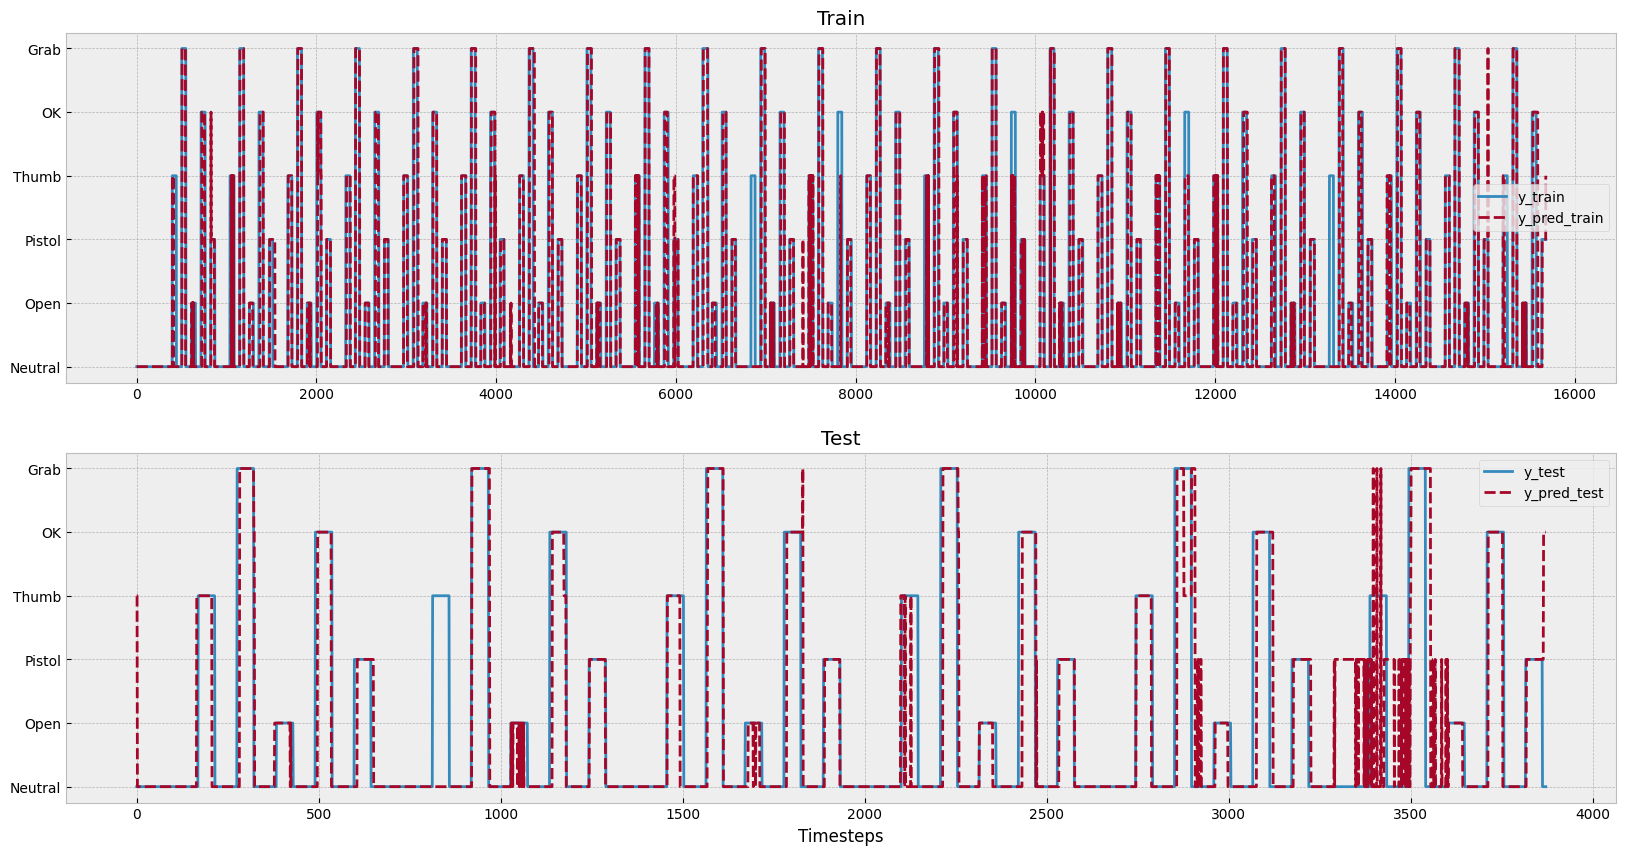

In [35]:
sgd_opt = sgd_model.set_params(**study_sgd.best_params)

model_report(sgd_opt, 17) 

### Random Forest

In [40]:
rf_model = ens.RandomForestClassifier()

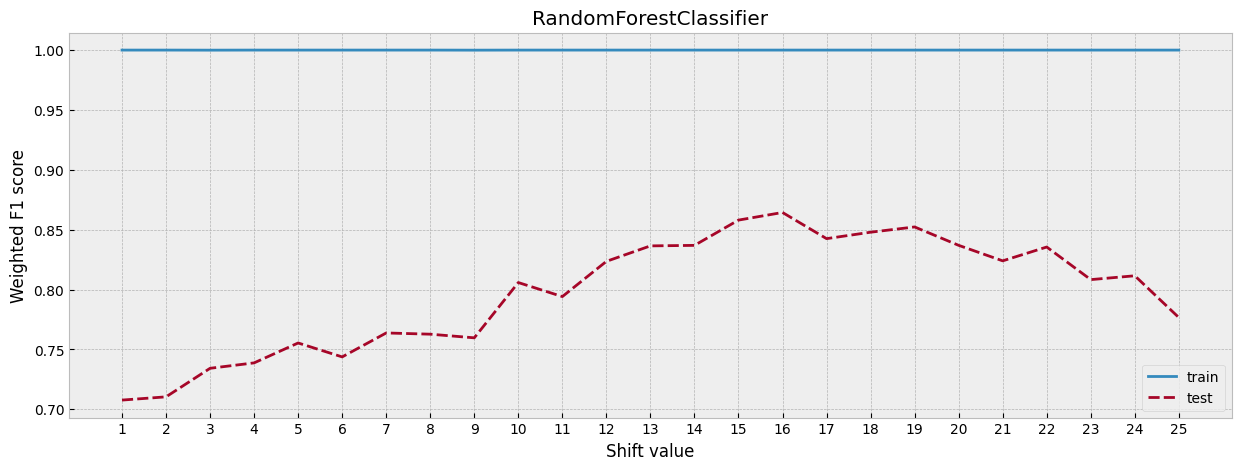

In [41]:
show_shift_plot(rf_model) 

Train:  100.0 %

Test:   86.12 %


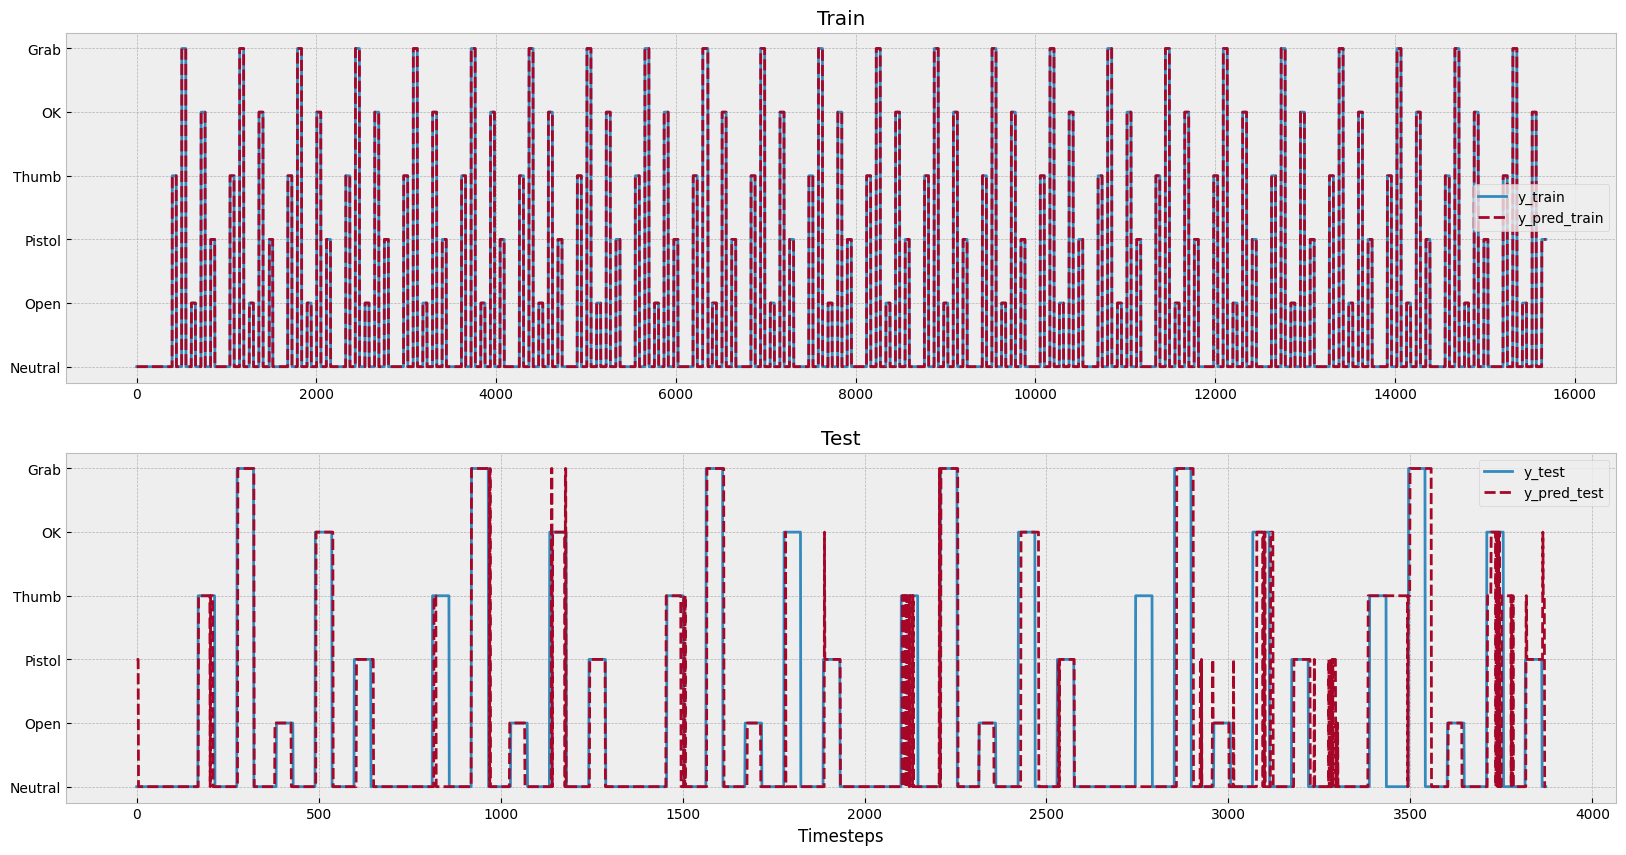

In [42]:
model_report(rf_model, 16)

In [43]:
def opt_forest(trial: optuna.trial.Trial):
    model = ens.RandomForestClassifier(
        n_estimators = trial.suggest_int('n_estimators', 50, 500, step=10),
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']), 
        max_depth = trial.suggest_int('max_depth', 2, 30),
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10),
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10),
        random_state = RS
    )
    score = model_score(model, 16)
    
    return score


study_forest = optuna.create_study(study_name='Random Forest', direction='maximize')

study_forest.optimize(opt_forest, n_trials=30)

[I 2024-01-27 21:50:33,567] A new study created in memory with name: Random Forest
[I 2024-01-27 21:50:40,567] Trial 0 finished with value: 0.8788915374859335 and parameters: {'n_estimators': 300, 'criterion': 'log_loss', 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8788915374859335.
[I 2024-01-27 21:50:56,468] Trial 1 finished with value: 0.8828755156691612 and parameters: {'n_estimators': 500, 'criterion': 'log_loss', 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8828755156691612.
[I 2024-01-27 21:51:03,120] Trial 2 finished with value: 0.8621905453119684 and parameters: {'n_estimators': 360, 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8828755156691612.
[I 2024-01-27 21:51:07,484] Trial 3 finished with value: 0.8811469500380558 and parameters: {'n_estimators': 140, 'criterion': 'log_loss', 'max_depth': 17, 'min_sa

Train:  96.2 %

Test:   88.19 %


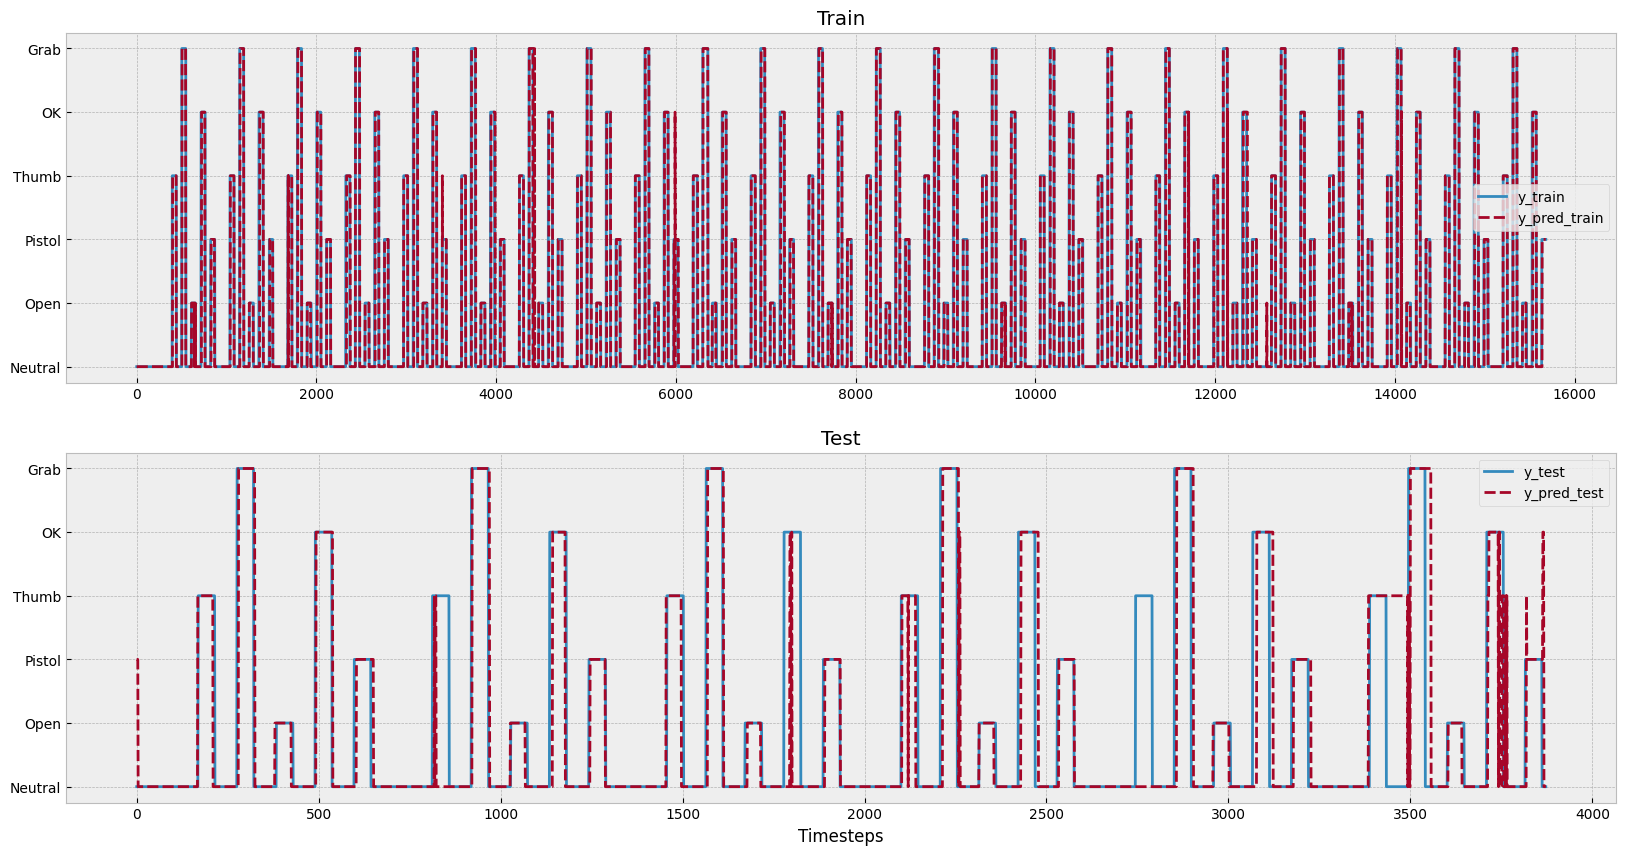

In [44]:
rf_opt = rf_model.set_params(**study_forest.best_params)

model_report(rf_opt, 16)

### KNN

In [45]:
knn_model = n.KNeighborsClassifier()

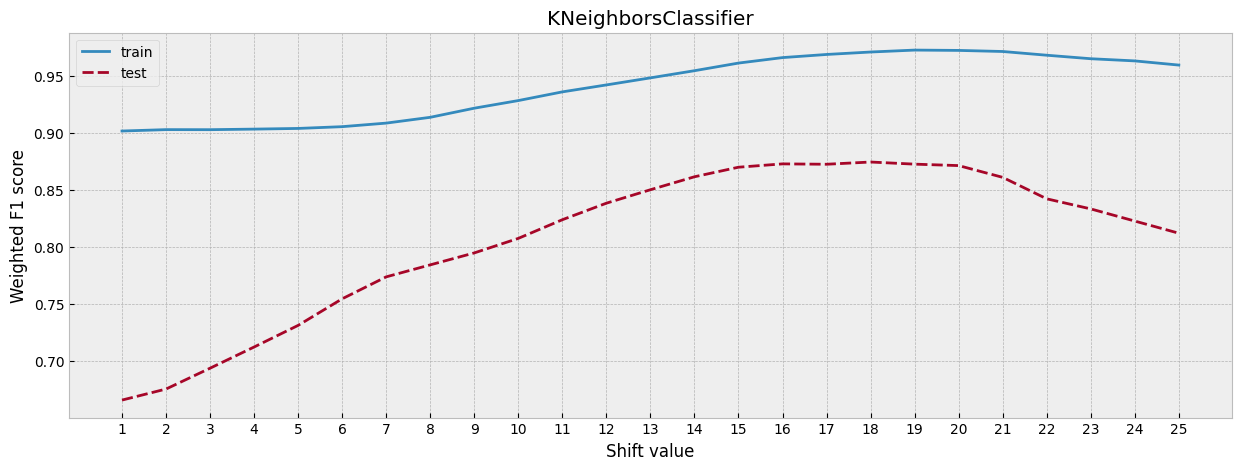

In [46]:
show_shift_plot(knn_model)

Train:  97.11 %

Test:   87.46 %


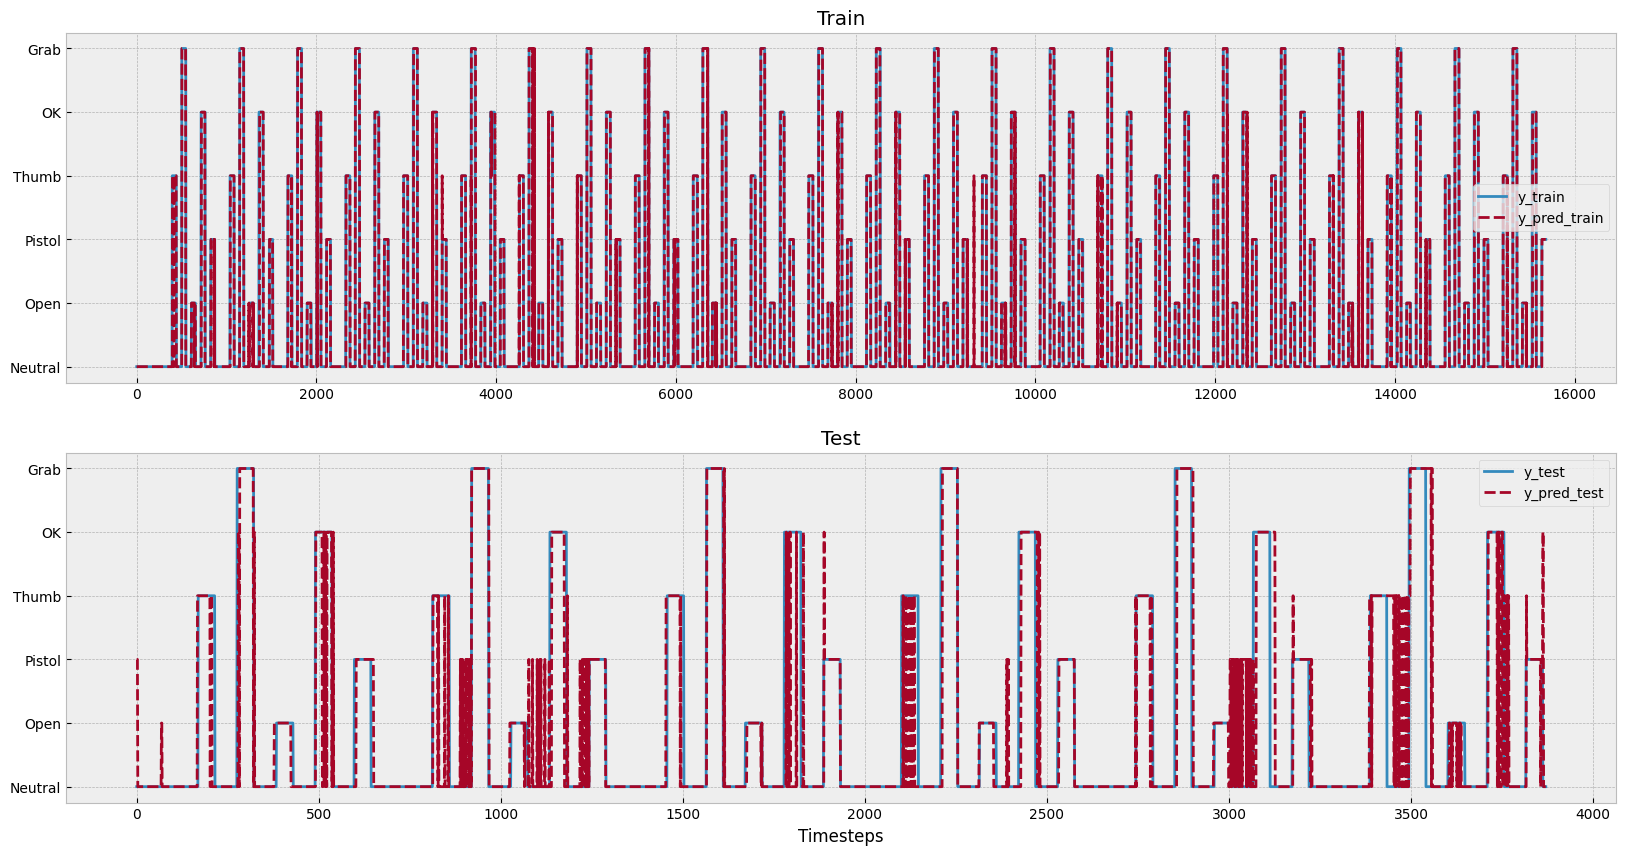

In [47]:
model_report(knn_model, 18)

In [48]:
def opt_knn(trial: optuna.trial.Trial):
    model = n.KNeighborsClassifier(
        n_neighbors = trial.suggest_int('n_neighbors', 2, 10), 
        weights = trial.suggest_categorical('weights', ['uniform', 'distance']), 
        leaf_size = trial.suggest_int('leaf_size', 1, 100), 
        p = trial.suggest_int('p', 1, 2)
    )
    score = model_score(model, 18)
    
    return score
    

study_knn = optuna.create_study(study_name='KNN', direction='maximize')

study_knn.optimize(opt_knn, n_trials=30)

[I 2024-01-27 21:56:27,813] A new study created in memory with name: KNN
[I 2024-01-27 21:56:28,031] Trial 0 finished with value: 0.8845396122650774 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 46, 'p': 2}. Best is trial 0 with value: 0.8845396122650774.
[I 2024-01-27 21:56:28,283] Trial 1 finished with value: 0.8743988131206407 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 3, 'p': 1}. Best is trial 0 with value: 0.8845396122650774.
[I 2024-01-27 21:56:28,531] Trial 2 finished with value: 0.8652144908428246 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 36, 'p': 1}. Best is trial 0 with value: 0.8845396122650774.
[I 2024-01-27 21:56:28,715] Trial 3 finished with value: 0.8888505954485516 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 43, 'p': 2}. Best is trial 3 with value: 0.8888505954485516.
[I 2024-01-27 21:56:28,864] Trial 4 finished with value: 0.8293627897645108 and parameters: {'n_nei

Train:  100.0 %

Test:   89.87 %


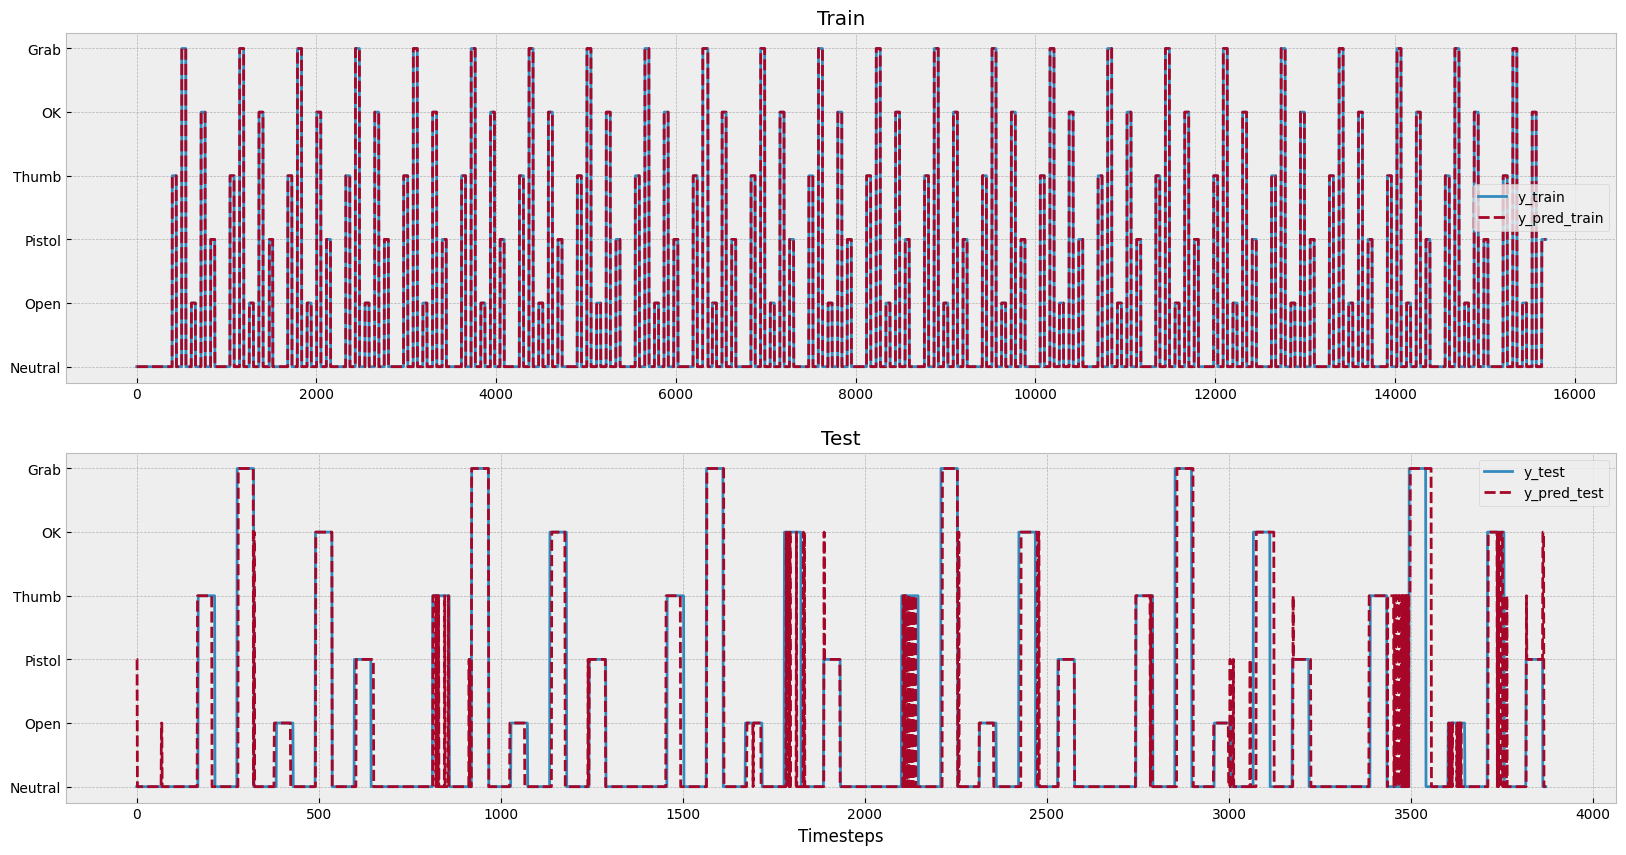

In [49]:
knn_opt = knn_model.set_params(**study_knn.best_params)

model_report(knn_opt, 18) 

### SVM

In [50]:
svm_model = svm.SVC(random_state=RS)

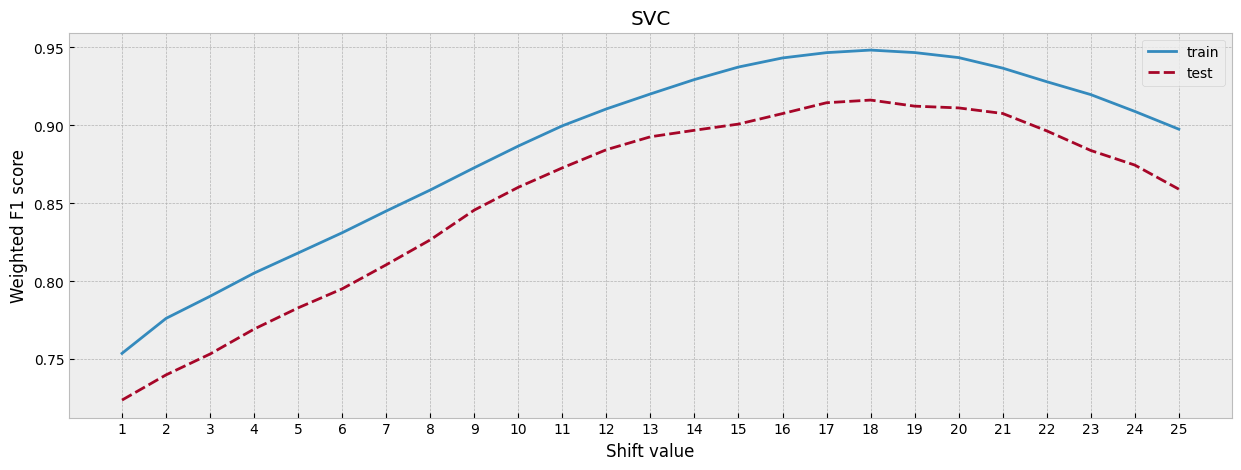

In [51]:
show_shift_plot(svm_model)

Train:  94.82 %

Test:   91.62 %


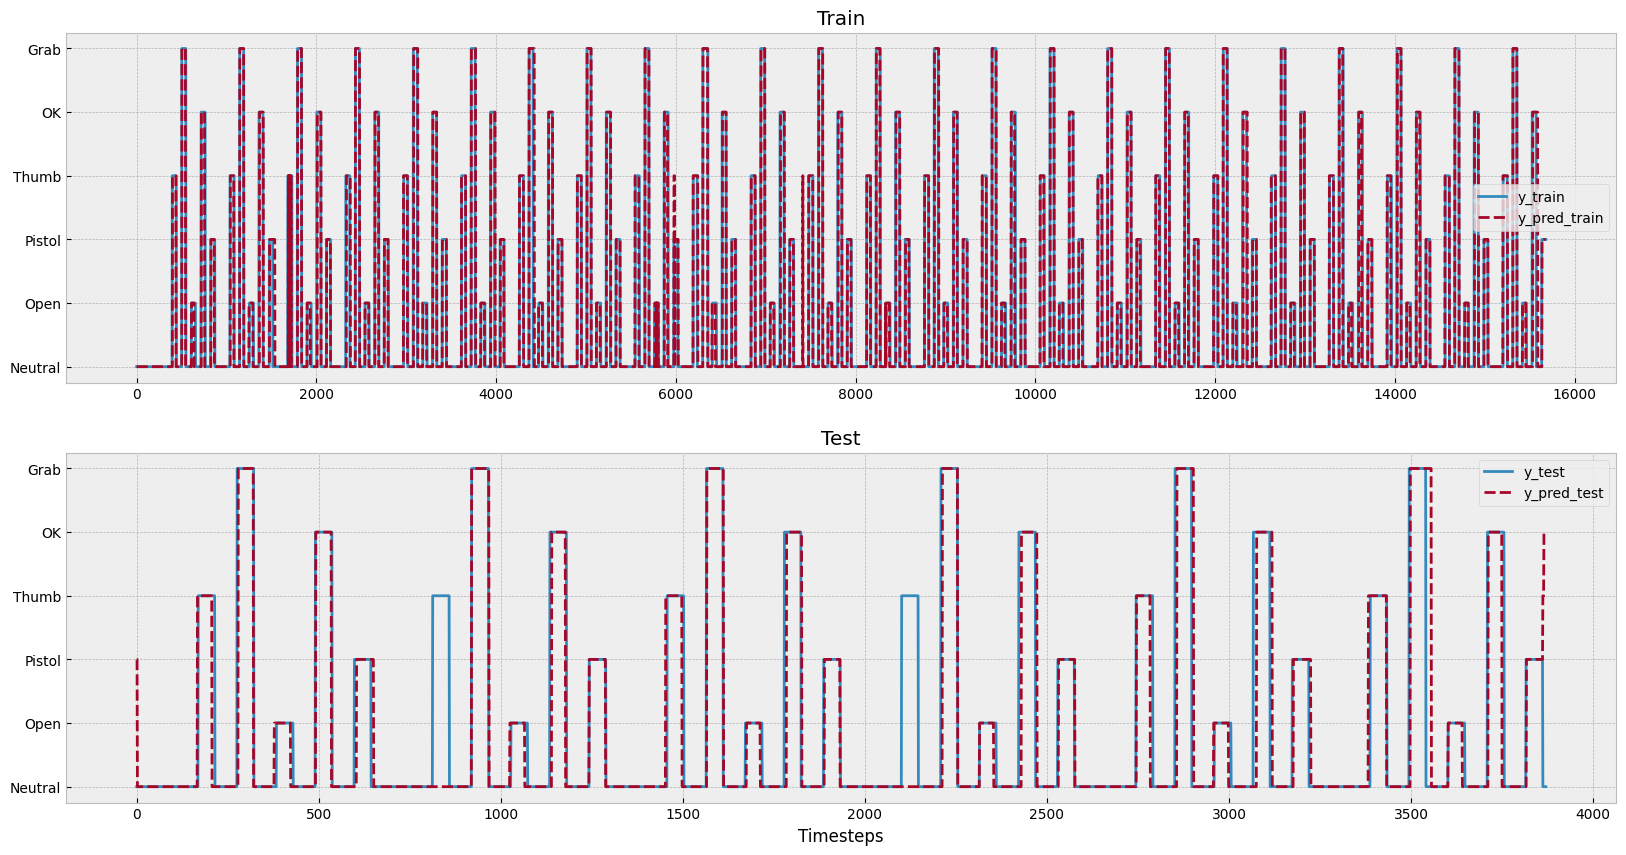

In [52]:
model_report(svm_model, 18) 

In [53]:
def opt_svm(trial: optuna.trial.Trial):
    model = svm.SVC(
        C = trial.suggest_float('C', 0.00001, 5), 
        decision_function_shape = trial.suggest_categorical(
            'decision_function_shape', ['ovo', 'ovr']), 
        max_iter = trial.suggest_int('max_iter', 100, 10000, step=100)
    )
    score = model_score(model, 18)
    
    return score
    

study_svm = optuna.create_study(study_name='SVM', direction='maximize')

study_svm.optimize(opt_svm, n_trials=30)

[I 2024-01-27 22:00:21,201] A new study created in memory with name: SVM
[I 2024-01-27 22:00:22,934] Trial 0 finished with value: 0.9134677362405234 and parameters: {'C': 3.2806129649219082, 'decision_function_shape': 'ovo', 'max_iter': 4700}. Best is trial 0 with value: 0.9134677362405234.
[I 2024-01-27 22:00:24,617] Trial 1 finished with value: 0.7976157417868293 and parameters: {'C': 0.5994412019924771, 'decision_function_shape': 'ovo', 'max_iter': 300}. Best is trial 0 with value: 0.9134677362405234.
[I 2024-01-27 22:00:26,446] Trial 2 finished with value: 0.9139644276515414 and parameters: {'C': 3.4132827173586153, 'decision_function_shape': 'ovo', 'max_iter': 4500}. Best is trial 2 with value: 0.9139644276515414.
[I 2024-01-27 22:00:28,245] Trial 3 finished with value: 0.9130465120627456 and parameters: {'C': 3.255522402556567, 'decision_function_shape': 'ovo', 'max_iter': 8500}. Best is trial 2 with value: 0.9139644276515414.
[I 2024-01-27 22:00:30,350] Trial 4 finished with val

Train:  95.14 %

Test:   91.68 %


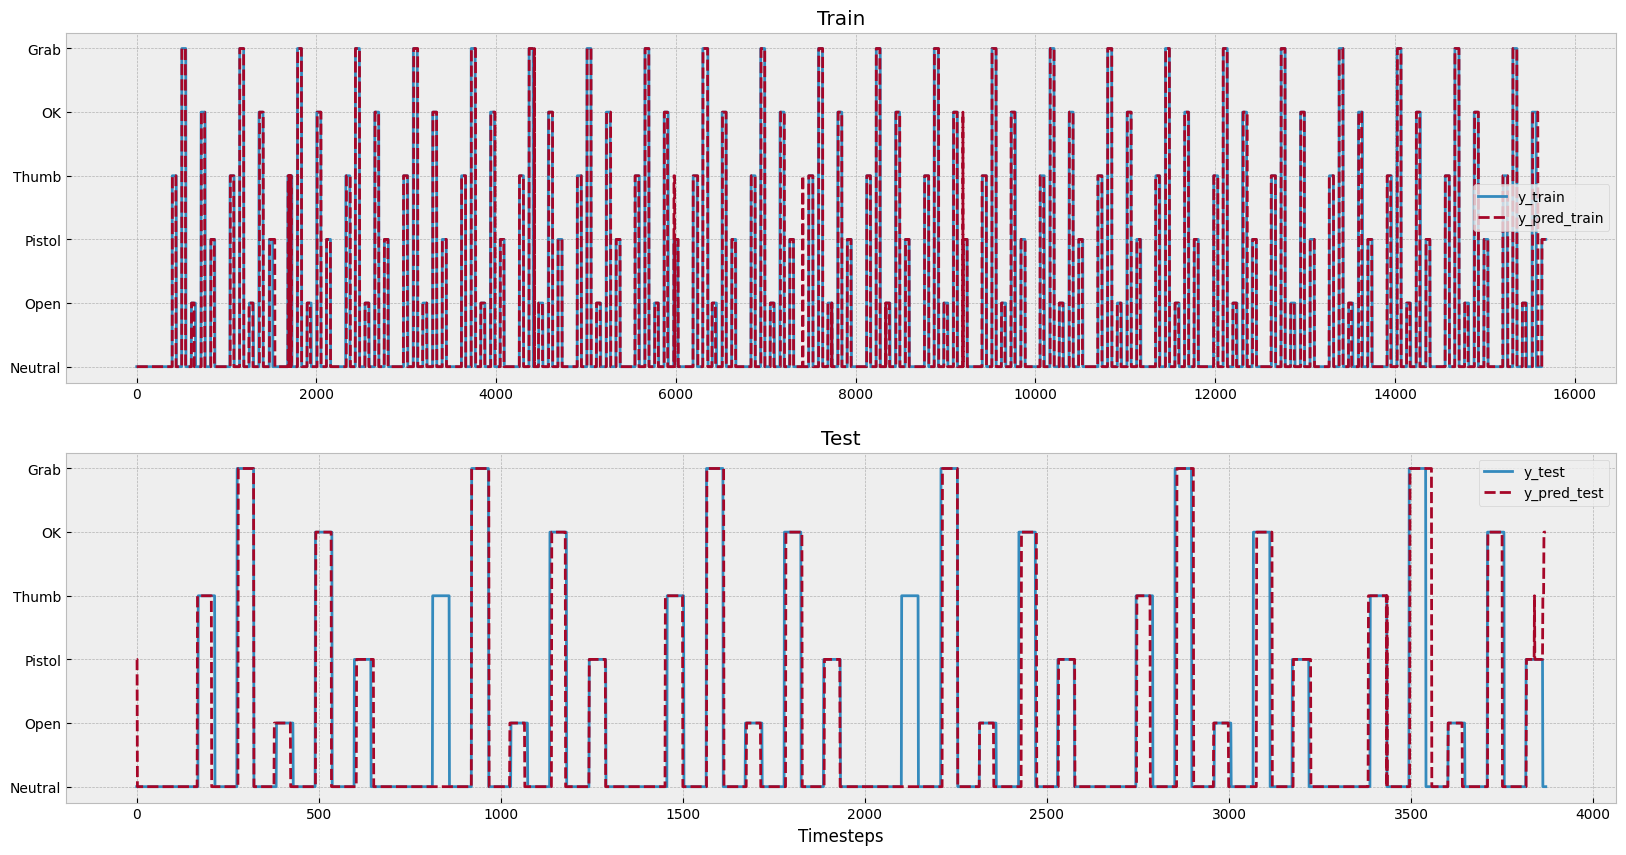

In [54]:
svm_opt = svm_model.set_params(**study_svm.best_params)

model_report(svm_opt, 18)

### Voting (bonus)

In [55]:
vote_model = ens.VotingClassifier(
    estimators = [ 
        ('lgr', base_opt), 
        ('knn', knn_opt), 
        ('svm', svm_opt)
    ]
)

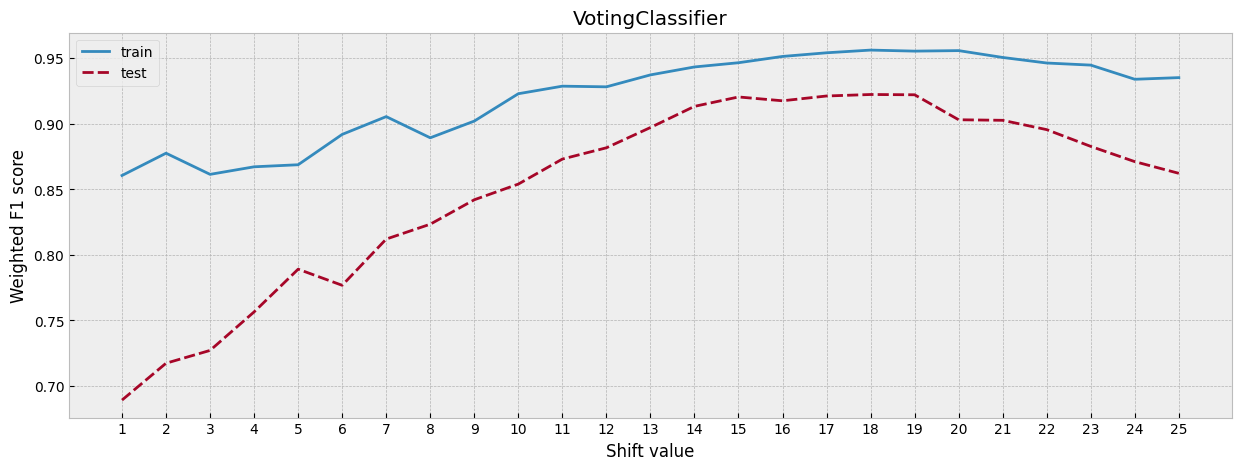

In [56]:
show_shift_plot(vote_model) 

[Voting] ...................... (1 of 3) Processing lgr, total=   0.8s
[Voting] ...................... (2 of 3) Processing knn, total=   0.0s
[Voting] ...................... (3 of 3) Processing svm, total=   1.1s
Train:  95.54 %

Test:   92.21 %


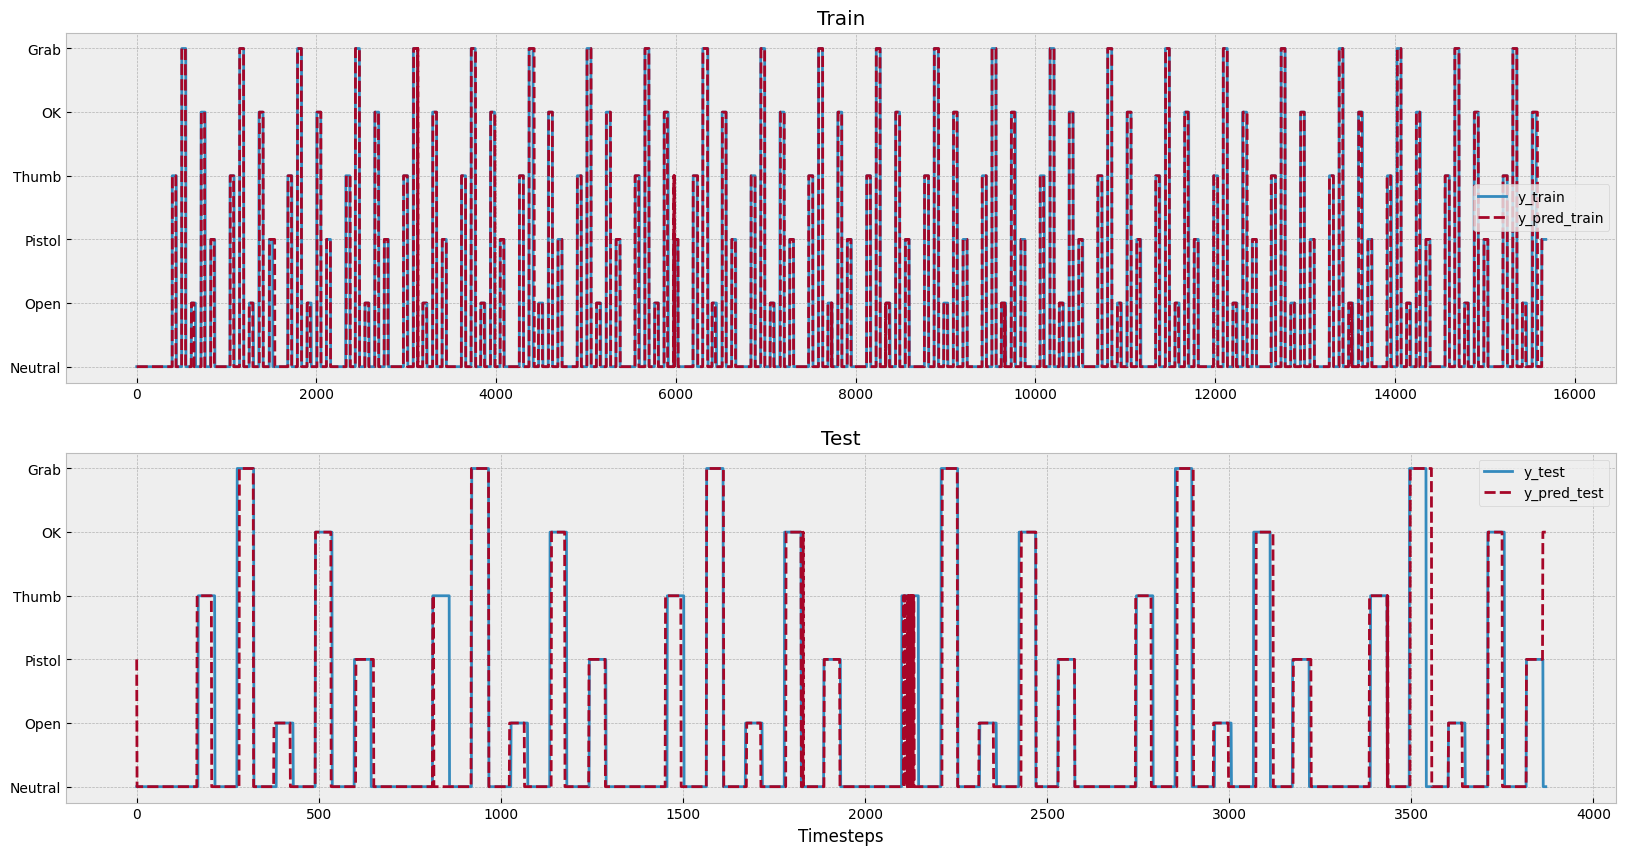

In [66]:
vote_model.set_params(**{'verbose': True})

model_report(vote_model, 19) 

-----

# Real-time inference

In [58]:
import time
import serial 
from IPython.display import clear_output

In [74]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
]

    
def get_crc(data, count):
    result = 0x00
    l = count
    
    while count > 0:   
        result = crc_table[result ^ data[l-count]]
        count -= 1
        
    return result


def drv_abs_one(ser, control):
    if ser is None:
        return
    
    pack = np.array(([80, 0x01, 0xBB, 6] + 
                     [c for c in control] + 
                     [0]), 
                    dtype='uint8')
    pack[-1] = get_crc(pack[1:], 9)
    
    return pack, ser.write(bytearray(pack))

## Inference Utils: Put your code here

In [75]:
model = svm_opt

model.get_params()

{'C': 1.6961195912618352,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovo',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': 400,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [81]:
def preprocessing(x):
    # x - sample vector
    x = pd.DataFrame(x)
    
    x_std = x.std(axis=0).sort_values()
    x_good_i = (x_std
                .where(gest_std >= 10)
                .dropna()
                .index)

    x_omg_ch = x.loc[:, x_good_i].drop('28', axis=1) 
    
    y = scaler.transform(x_omg_ch)
    return y

def inference(x):
    y = model.predict([x])
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = (x*0.1) + (prev*0.9) # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x/100, 0, 1) * 100).astype(int)
    return y

## Inference

### Offline (dataset)

In [77]:
df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

(3889, 65)


In [82]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0

y_previous = None
y_dct = {
    'omg_sample': [],
    'enc_sample': [],
    'sample_preprocessed': [],
    'y_predicted': [],
    'y_postprocessed': [],
    'y_commands': [],
}

while True:    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    
    # [Inference]
    y_predicted = inference(sample_preprocessed)
    
    # [Inference Postprocessing]
    y_postprocessed = postprocessing(y_predicted, y_previous)
    
    # [Commands composition]
    y_commands = commands(y_postprocessed)
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    
    assert ts_diff < TIMEOUT, 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 

ValueError: at least one array or dtype is required

In [ ]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

In [ ]:
fig = plt.figure(figsize=(10, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [ ]:
print(m.classification_report(y_test, y_dct['y_commands'], target_names=GESTURES))

### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 